# ===============================
# 📚 Etape 0: Importer les librairies
# ===============================


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib

# ===============================
# Etape 1: Charger les images 
# ===============================

In [ ]:
def load_images_from_folder(folder, img_size=(64, 64), classes_allowed=('NORMAL', 'PNEUMONIA')):
    images = []
    labels = []
    for label in os.listdir(folder):
        if label not in classes_allowed:
            continue  # Ignore other classes if any
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                try:
                    img = load_img(img_path, target_size=img_size, color_mode="rgb")
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Warning: Could not Charger les images {img_path}. Skipping. Error: {e}")
    return np.array(images), np.array(labels)

# ===============================
# Etape 2: Définir les chemins d'accès et charger
# ===============================

In [ ]:
train_dir = 'chest_Xray/train/'
test_dir = 'chest_Xray/test/'
val_dir = 'chest_Xray/val/'

X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)
X_val, y_val = load_images_from_folder(val_dir)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}, Val samples: {len(X_val)}")
print(f"Train labels distribution: {np.unique(y_train, return_counts=True)}")


# ===============================
# Etape 3: Contrôle visuel
# ===============================

In [ ]:
def show_sample_images(X, y, n=5):
    indices = random.sample(range(len(X)), n)
    for i in indices:
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
        plt.show()

# show_sample_images(X_train, y_train)  #uncomment to see


# ===============================
# Etape 4: Prétraitement 
# ===============================

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
y_val_enc = label_encoder.transform(y_val)

print(f"Classes: {label_encoder.classes_}")  # should print ['NORMAL' 'PNEUMONIA']


# ===============================
# Etape 5: Entrainement de l'arbre de décision
# ===============================

In [ ]:
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(X_train_flat, y_train_enc)

# ===============================
# Etape 6: Evaluation
# ===============================

In [ ]:
y_pred = model.predict(X_test_flat)

print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

# Création du dossier avec les résultats
os.makedirs("results", exist_ok=True)

# Création de la matrice de confusion
cm = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('results/confusion_matrix.png')
plt.close()


# ROC Curve (binary only) Bonus
# if len(label_encoder.classes_) == 2:
#    y_proba = model.predict_proba(X_test_flat)[:, 1]
#    roc_auc = roc_auc_score(y_test_enc, y_proba)
#    print(f"ROC-AUC Score: {roc_auc:.4f}")
#    
#    RocCurveDisplay.from_predictions(y_test_enc, y_proba)
#    plt.title('ROC Curve')
#    plt.savefig('results/roc_curve.png')
#    plt.close()

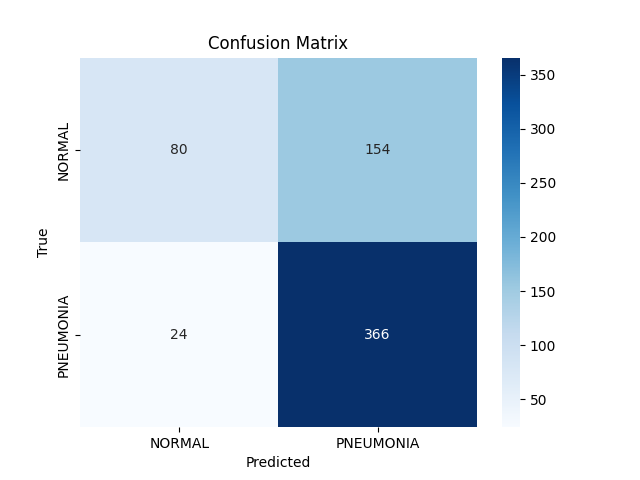

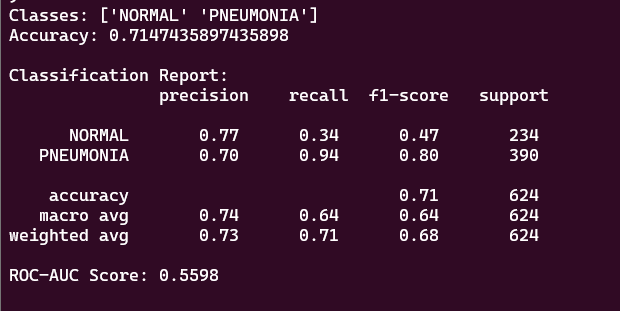

# ===============================
# Etape 7: Cross-Validation
# ===============================

In [ ]:
cv_scores = cross_val_score(model, X_train_flat, y_train_enc, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# ===============================
# Etape 8: Tuning d'Hyperparamètre
# ===============================

In [ ]:
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_flat, y_train_enc)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# ===============================
# Etape 9: Enregistrement du model
# ===============================

joblib.dump(best_model, 'model_decision_tree.pkl')
print("Best model saved as model_decision_tree.pkl")


# ===============================
# Etape 10: Visualiser l'arbre
# ===============================

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, max_depth=2, class_names=label_encoder.classes_)
plt.title('Partial Decision Tree Visualization (First 2 Levels)')
plt.savefig('results/decision_tree_partial.png')
plt.close()

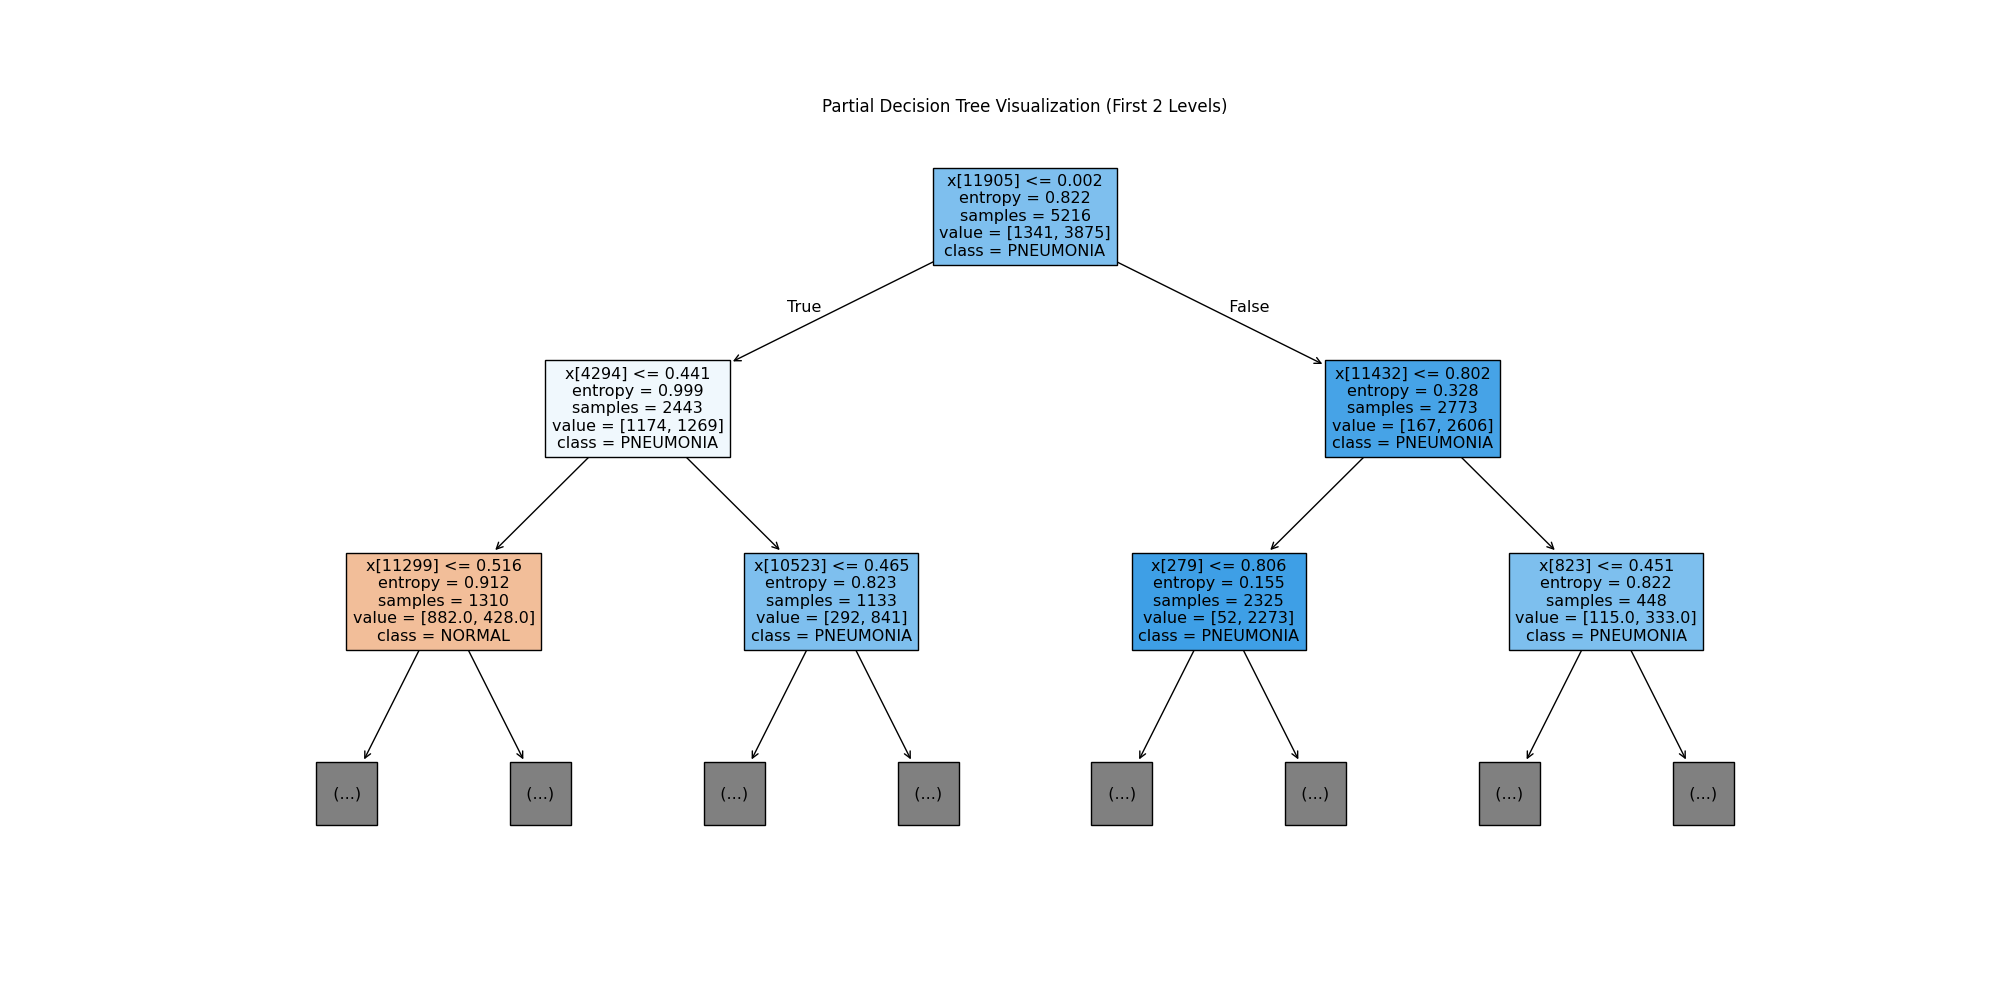